In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [6]:
ranked_shops = pd.read_csv('../data/ranked_shops.csv')


In [7]:
ranked_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      463 non-null    int64  
 1   Shop_Name                       463 non-null    object 
 2   Address                         463 non-null    object 
 3   Latitude                        463 non-null    float64
 4   Longitude                       463 non-null    float64
 5   Rating                          463 non-null    float64
 6   Reviews_Count                   463 non-null    int64  
 7   Place_ID                        463 non-null    object 
 8   Price_Level                     463 non-null    float64
 9   types                           463 non-null    object 
 10  Borough                         463 non-null    object 
 11  Property_Value_2017             463 non-null    float64
 12  Earnings_2021                   463 

Prepare the data:

In [8]:
# Define the feature columns
feature_columns = [
    'Rating', 'Reviews_Count', 'Price_Level', 'Property_Value_2017',
    'Earnings_2021', 'composite_score'
]


# K-means

In [15]:
# Extract features from the dataset
X = ranked_shops[feature_columns]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)


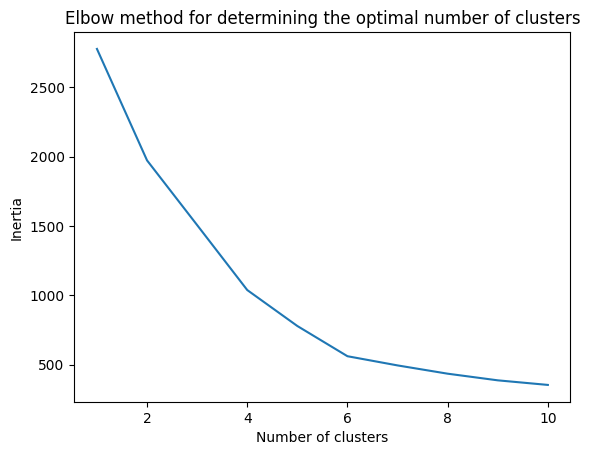

In [16]:
# Plot the inertia values
import matplotlib.pyplot as plt

plt.plot(range(1, 11), inertia_values)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method for determining the optimal number of clusters')
plt.show()


In [19]:

# Train the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assign the clusters to the dataset
ranked_shops['cluster'] = kmeans.labels_

# EDA to explore the output

In [21]:
print(ranked_shops.dtypes)


Unnamed: 0                          int64
Shop_Name                          object
Address                            object
Latitude                          float64
Longitude                         float64
Rating                            float64
Reviews_Count                       int64
Place_ID                           object
Price_Level                       float64
types                              object
Borough                            object
Property_Value_2017               float64
Earnings_2021                     float64
IMD_Rank                          float64
Income_Rank                       float64
composite_score                   float64
Rating_normalized                 float64
Property_Value_2017_normalized    float64
Earnings_2021_normalized          float64
Reviews_Count_normalized          float64
Price_Level_normalized            float64
Rank                              float64
Cluster                             int32
cluster                           

In [20]:
# Group the data by cluster labels and calculate the mean for each group
#cluster_means = ranked_shops.groupby('cluster').mean()

# Display the cluster means
# print(cluster_means)


TypeError: Could not convert One Vintage2o2st NewsVintage ModesDream RetroLanaTS Clothingwornwell vintage clothingOOTO LONDONDreamtimeVintage80scasualsUrban Closet LondonJama Vintage Clothing Co.Accessories of OldR13fitnessBajaboutiqueGBReBelishedClerkenwell Vintage Fashion FairBerty and Gerty VintageCamden Threads - An online shop for the best independent brands and vintage boutiquesOuterLimitz VintageWAI VI KI . LTDSvarelleMiniola VintageAlpha Vintage StoreVintage ChairsRejuvenate - Something for everyoneVintage storeArchive SixThe yardMō Ichido VintagePink InkSunday market stock vintageVintage Velvet ClothinglivewithfashionAcademy Vintage Reprothe never notSixQDVintage CultureFrankie Lou VintageHouse of VintageThe Vintage ExchangeSenseBumbelina Vintage to numeric

In [23]:
# Summary statistics for each cluster
cluster_summary = ranked_shops.groupby('cluster').describe()
display(cluster_summary)


Unnamed: 0                                                        
             count        mean        std    min     25%    50%     75%   
cluster                                                                   
0             42.0  434.738095  24.923355  362.0  430.25  441.5  451.75  \
1            162.0   87.086420  58.983985    0.0   40.25   80.5  121.75   
2            259.0  287.976834  82.265214  115.0  222.50  291.0  355.50   

               Latitude             ...    Rank        Cluster             
           max    count       mean  ...     75%    max   count      mean   
cluster                             ...                                    
0        462.0     42.0  51.506153  ...  447.00  463.0    42.0  2.833333  \
1        280.0    162.0  51.499397  ...  122.75  281.0   162.0  2.222222   
2        435.0    259.0  51.508853  ...  356.50  436.0   259.0  4.613900   

                                            
              std  min  25%  50%  75%  max  
cluster                                     
0        1.885977  2.0  2.0  2.0  2.0  7.0  
1        1.294998  1.0  1.0  3.0  3.0  8.0  
2        4.369286  0.0  0.0  5.0  9.0  9.0  

[3 rows x 144 columns]

## Random forest model:

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the data
X_rf = ranked_shops.drop(['Unnamed: 0', 'Shop_Name', 'Address', 'Place_ID', 'types', 'Borough', 'cluster'], axis=1)
y_rf = ranked_shops['cluster']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importances
feature_importances = pd.DataFrame({'feature': X_rf.columns, 'importance': rf.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
display(feature_importances)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.97      0.98        62
           2       0.97      1.00      0.98        60

    accuracy                           0.99       139
   macro avg       0.99      0.99      0.99       139
weighted avg       0.99      0.99      0.99       139

Accuracy: 0.9856115107913669


,feature,importance
9,composite_score,0.143616
12,Earnings_2021_normalized,0.122579
15,Rank,0.114501
5,Property_Value_2017,0.114191
6,Earnings_2021,0.096823
11,Property_Value_2017_normalized,0.075342
10,Rating_normalized,0.066587
2,Rating,0.063567
8,Income_Rank,0.051531
13,Reviews_Count_normalized,0.047834


According to the table, the top 5 most important features are:

composite_score (0.143616)
Earnings_2021_normalized (0.122579)
Rank (0.114501)
Property_Value_2017 (0.114191)
Earnings_2021 (0.096823)
These features contribute the most to the model's ability to correctly predict the cluster labels.